In [1]:
%pip install pydub
%pip install noisereduce
%pip install pyaudio
%pip install json-tricks

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from json_tricks import load

import numpy as np

import librosa
from pydub import AudioSegment, effects
import noisereduce as nr

import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.models import load_model

import matplotlib.pyplot as plt

c:\Users\Admin\Desktop\SER\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
saved_model_path = 'C:/Users/Admin/Desktop/SER/lstmmodel.json'
saved_weights_path = 'C:/Users/Admin/Desktop/SER/checkpoints/best_weights.keras'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 339, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None


In [1]:
def preprocess(file_path, frame_length = 2048, hop_length = 512):
    '''
    A process to an audio .wav file before execcuting a prediction.
      Arguments:
      - file_path - The system path to the audio file.
      - frame_length - Length of the frame over which to compute the speech features. default: 2048
      - hop_length - Number of samples to advance for each frame. default: 512

      Return:
        'X_3D' variable, containing a shape of: (batch, timesteps, feature) for a single file (batch = 1).
    ''' 
    # Fetch sample rate.
    _, sr = librosa.load(path = file_path, sr = None)
    # Load audio file
    rawsound = AudioSegment.from_file(file_path, duration = None) 
    # Normalize to 5 dBFS 
    normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transform the audio file to np.array of samples
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32') 
    # Noise reduction                  
    final_x = nr.reduce_noise(normal_x, sr=sr, use_tensorflow=True)
        
        
    f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length, center=True, pad_mode='reflect').T # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length,center=True).T # ZCR
    f3 = librosa.feature.mfcc(final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length).T # MFCC   
    X = np.concatenate((f1, f2, f3), axis = 1)
    
    X_3D = np.expand_dims(X, axis=0)
    
    return X_3D

In [2]:
# Emotions list is created for a readable form of the model prediction.

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'   
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100


** Processing uploaded audio file **
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


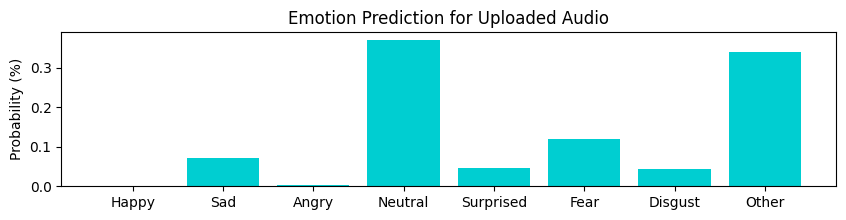

Predicted Emotion: Neutral
** Analysis Complete **


In [15]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json

# Load the model
def load_model(json_path, weights_path):
    with open(json_path, 'r') as file:
        model = model_from_json(file.read())
    model.load_weights(weights_path)
    return model

# Preprocess audio file to match model input
def preprocess(file_path):
    import librosa
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=24414)  # Match RATE in your original code
    
    # Extract MFCCs (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=15)  # Correctly specify 'y' and 'sr'
    
    # Pad or truncate to the expected timesteps
    expected_length = 339
    if mfccs.shape[1] < expected_length:
        padding = expected_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, padding)), mode='constant')
    else:
        mfccs = mfccs[:, :expected_length]
    
    # Reshape for the model
    return np.expand_dims(mfccs.T, axis=0)


# Load the model
model = load_model('C:/Users/Admin/Desktop/SER/lstmmodel.json', 'C:/Users/Admin/Desktop/SER/checkpoints/best_weights.keras')

# Emotion labels
emo_list = ['Happy', 'Sad', 'Angry', 'Neutral', 'Surprised', 'Fear', 'Disgust', 'Other']

# Function to process the uploaded file and make predictions
def analyze_audio(file_path):
    print("** Processing uploaded audio file **")
    
    # Preprocess audio file
    x = preprocess(file_path)
    
    # Model's prediction => an array of emotion probabilities
    predictions = model.predict(x)  # Removed 'use_multiprocessing'
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0)  # Remove unnecessary dimensions
    
    # Plot emotion probabilities for the audio
    fig = plt.figure(figsize=(10, 2))
    plt.bar(emo_list, pred_np, color='darkturquoise')
    plt.ylabel("Probability (%)")
    plt.title("Emotion Prediction for Uploaded Audio")
    plt.show()
    
    # Get the most likely emotion
    max_emo = np.argmax(predictions)
    print('Predicted Emotion:', emo_list[max_emo])
    print("** Analysis Complete **")

# Simulate file upload for testing
file_path = "C:/Users/Admin/Desktop/SER/Dataset/RAVDESS/Actor_01/03-01-02-01-02-02-01.wav"  # Replace this with the actual uploaded file path
analyze_audio(file_path)


** Processing uploaded audio file **
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


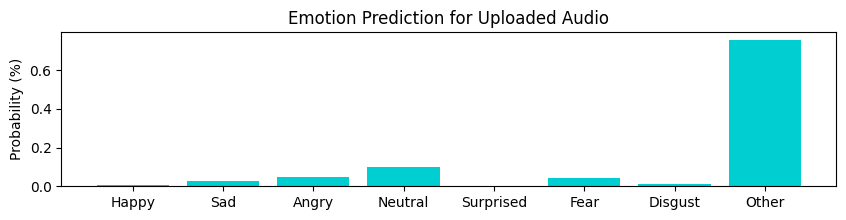

Predicted Emotion: Other
** Analysis Complete **


In [17]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json

# Load the model
def load_model(json_path, weights_path):
    with open(json_path, 'r') as file:
        model = model_from_json(file.read())
    model.load_weights(weights_path)
    return model

# Preprocess audio file to match model input
def preprocess(file_path):
    import librosa
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=24414)  # Match RATE in your original code
    
    # Extract MFCCs (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=15)  # Correctly specify 'y' and 'sr'
    
    # Pad or truncate to the expected timesteps
    expected_length = 339
    if mfccs.shape[1] < expected_length:
        padding = expected_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, padding)), mode='constant')
    else:
        mfccs = mfccs[:, :expected_length]
    
    # Reshape for the model
    return np.expand_dims(mfccs.T, axis=0)


# Load the model
model = load_model('C:/Users/Admin/Desktop/SER/lstmmodel.json', 'C:/Users/Admin/Desktop/SER/checkpoints/best_weights.keras')

# Emotion labels
emo_list = ['Happy', 'Sad', 'Angry', 'Neutral', 'Surprised', 'Fear', 'Disgust', 'Other']

# Function to process the uploaded file and make predictions
def analyze_audio(file_path):
    print("** Processing uploaded audio file **")
    
    # Preprocess audio file
    x = preprocess(file_path)
    
    # Model's prediction => an array of emotion probabilities
    predictions = model.predict(x)  # Removed 'use_multiprocessing'
    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0)  # Remove unnecessary dimensions
    
    # Plot emotion probabilities for the audio
    fig = plt.figure(figsize=(10, 2))
    plt.bar(emo_list, pred_np, color='darkturquoise')
    plt.ylabel("Probability (%)")
    plt.title("Emotion Prediction for Uploaded Audio")
    plt.show()
    
    # Get the most likely emotion
    max_emo = np.argmax(predictions)
    print('Predicted Emotion:', emo_list[max_emo])
    print("** Analysis Complete **")

# Simulate file upload for testing
file_path = "C:/Users/Admin/Desktop/SER/Dataset/RAVDESS/Actor_14/03-01-01-01-01-02-14.wav"  # Replace this with the actual uploaded file path
analyze_audio(file_path)
